In [ ]:
!pip install PyWavelets
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft
from keras.models import Sequential

In [ ]:
file_path= '/content/drive/MyDrive/battery_concat.csv'
data=pd.read_csv(file_path, delimiter=',')

In [ ]:
data=data.dropna()
missing_values=data.isnull().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


In [ ]:
duplicates=data.duplicated()
print(data[duplicates])

Empty DataFrame
Columns: [Battery_id, Cycle Number, Voltage, Ambient temp, Current, Temperature, Current Load, Voltage Load, Time, Fluctuation Index, Skewness Index, Kurtosis Index, Capacity, SoC, Discharge Rate, Energy, Battery Voltage Slope, Voltage Range, Battery Impedance, Power, Temperature Deviation]
Index: []

[0 rows x 21 columns]


In [ ]:
data['RUL'] = data.groupby('Battery_id')['Cycle Number'].transform(lambda x: x.max() - x)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Battery_id             185721 non-null  int64  
 1   Cycle Number           185721 non-null  int64  
 2   Voltage                185721 non-null  float64
 3   Ambient temp           185721 non-null  int64  
 4   Current                185721 non-null  float64
 5   Temperature            185721 non-null  float64
 6   Current Load           185721 non-null  float64
 7   Voltage Load           185721 non-null  float64
 8   Time                   185721 non-null  float64
 9   Fluctuation Index      185721 non-null  float64
 10  Skewness Index         185721 non-null  float64
 11  Kurtosis Index         185721 non-null  float64
 12  Capacity               185721 non-null  float64
 13  SoC                    185721 non-null  float64
 14  Discharge Rate         185721 non-nu

In [ ]:
data.describe()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,RUL
count,185721.000000,185721.000000,185721.000000,185721.0,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,...,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,185721.000000,1.857210e+05,185721.000000
mean,8.252799,82.838758,3.497219,24.0,-1.832569,32.378997,1.465434,2.366494,1546.379935,0.230871,...,1.587423,79.371172,-0.916284,-1.587423,-0.000230,1.799526,-74.273992,-6.420762,-5.478633e-17,78.402846
std,4.743428,45.692247,0.251691,0.0,0.561405,4.027737,1.226874,0.751377,906.958628,0.023214,...,0.190001,9.500073,0.280702,0.190001,0.000041,0.220695,2608.931740,0.450070,3.908556e+00,44.454423
min,5.000000,1.000000,1.737030,24.0,-2.029098,22.350256,-2.000000,0.000000,0.000000,0.161813,...,1.172439,58.621975,-1.014549,-2.041423,-0.000308,1.493270,-20707.349523,-7.103982,-9.866722e+00,0.000000
25%,5.000000,45.000000,3.377653,24.0,-2.011418,29.570621,1.998200,2.410000,764.797000,0.220286,...,1.439171,71.958571,-1.005709,-1.752563,-0.000253,1.586603,-227.099963,-6.777915,-2.709754e+00,41.000000
50%,6.000000,81.000000,3.500859,24.0,-2.009015,32.355737,1.998800,2.558000,1537.031000,0.230603,...,1.567892,78.394616,-1.004508,-1.567892,-0.000226,1.757973,-65.330717,-6.501760,9.984370e-02,79.000000
75%,7.000000,120.000000,3.655751,24.0,-1.989974,35.420677,1.999000,2.718000,2307.485000,0.247784,...,1.752563,87.628142,-0.994987,-1.439171,-0.000214,2.015958,25.013362,-6.125274,3.015451e+00,115.000000
max,18.000000,168.000000,4.233325,24.0,0.014306,42.332522,2.000000,4.249000,3690.234000,0.272858,...,2.041423,102.071146,0.007153,-1.172439,-0.000068,2.459612,38750.363218,-5.076706,8.735434e+00,167.000000


In [ ]:
data.head()

,Battery_id,Cycle Number,Voltage,Ambient temp,Current,Temperature,Current Load,Voltage Load,Time,Fluctuation Index,...,Capacity,SoC,Discharge Rate,Energy,Battery Voltage Slope,Voltage Range,Battery Impedance,Power,Temperature Deviation,RUL
0,5,1,4.191492,24,-0.004902,24.330034,-0.0006,0.000,0.000,0.179017,...,1.862443,93.12215,-0.002451,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.242294,167
1,5,1,4.190749,24,-0.001478,24.325993,-0.0006,4.206,16.781,0.179017,...,1.862443,93.12215,-0.000739,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.246335,167
2,5,1,3.974871,24,-2.012528,24.389085,-1.9982,3.062,35.703,0.179017,...,1.862443,93.12215,-1.006264,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.183243,167
3,5,1,3.951717,24,-2.013979,24.544752,-1.9982,3.030,53.781,0.179017,...,1.862443,93.12215,-1.006990,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-8.027576,167
4,5,1,3.934352,24,-2.011144,24.731385,-1.9982,3.011,71.922,0.179017,...,1.862443,93.12215,-1.005572,-1.862443,-0.000206,1.579024,-177.515371,-6.463172,-7.840943,167


In [ ]:
columns_to_compare = ['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']
for column in columns_to_compare:
    correlation = data[column].corr(data['RUL'])
    print(f'Correlation coefficient between {column} and RUL: {correlation:.2f}')

Correlation coefficient between Battery_id and RUL: -0.07
Correlation coefficient between Cycle Number and RUL: -0.95
Correlation coefficient between Voltage and RUL: 0.14
Correlation coefficient between Ambient temp and RUL: nan
Correlation coefficient between Current and RUL: -0.13
Correlation coefficient between Temperature and RUL: -0.11
Correlation coefficient between Current Load and RUL: -0.43
Correlation coefficient between Voltage Load and RUL: 0.18
Correlation coefficient between Time and RUL: 0.12
Correlation coefficient between Fluctuation Index and RUL: -0.25
Correlation coefficient between Skewness Index and RUL: -0.40
Correlation coefficient between Kurtosis Index and RUL: 0.44
Correlation coefficient between Capacity and RUL: 0.94
Correlation coefficient between SoC and RUL: 0.94
Correlation coefficient between Discharge Rate and RUL: -0.13
Correlation coefficient between Energy and RUL: -0.94
Correlation coefficient between Battery Voltage Slope and RUL: 0.02
Correlati

In [ ]:
data.columns

Index(['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation',
       'RUL'],
      dtype='object')

In [ ]:
from sklearn.model_selection import GridSearchCV
input_data = data[['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
X = input_data
y = data['RUL']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score (neg MSE):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
print("Best model MSE:", mse_best)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6}
Best score (neg MSE): -0.010550280715903538
Best model MSE: 0.010416849765685014


In [ ]:
data.shape

(185721, 22)

Cross-Validation RMSE Scores: [0.63430506 0.65593316 0.59833214 0.66119136 0.65940725]
Mean Cross-Validation RMSE: 0.6418337920895772
Test MSE: 0.37794075082758083
Test RMSE: 0.6147688596762045
R²: 0.9998073577880859
Adjusted R²: 0.9998072540049743


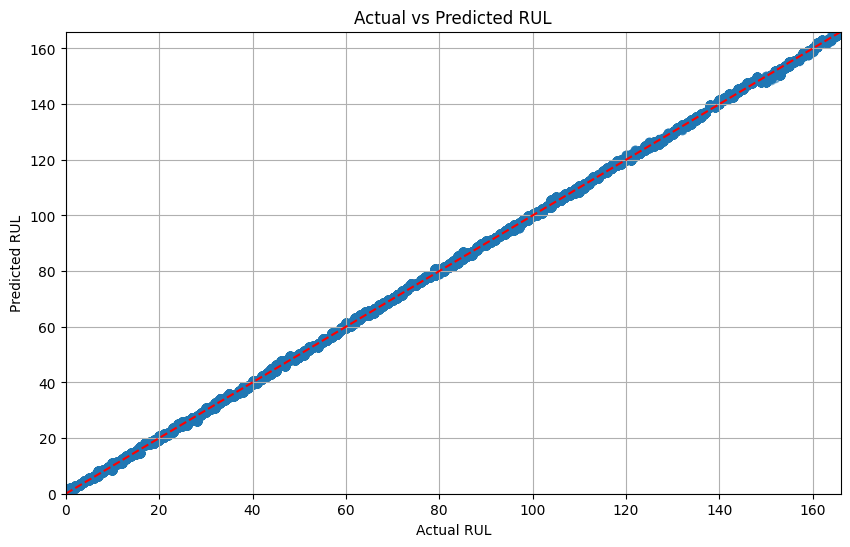

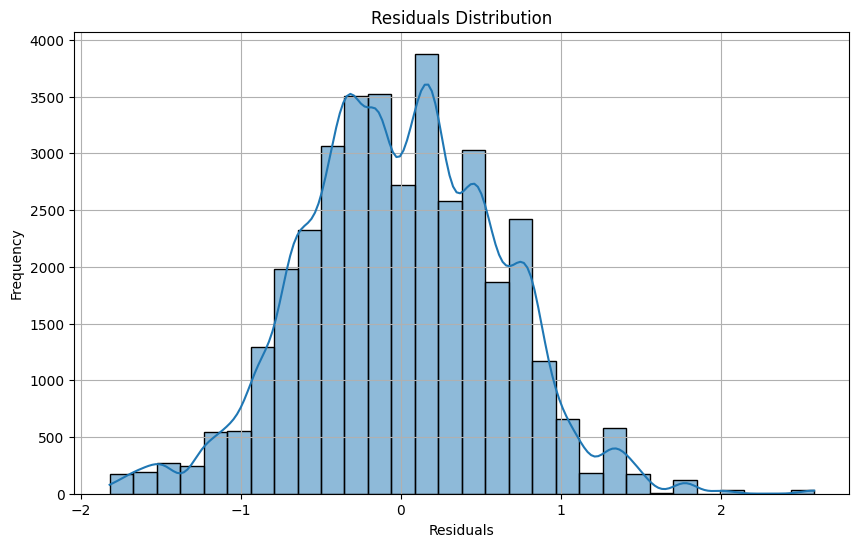

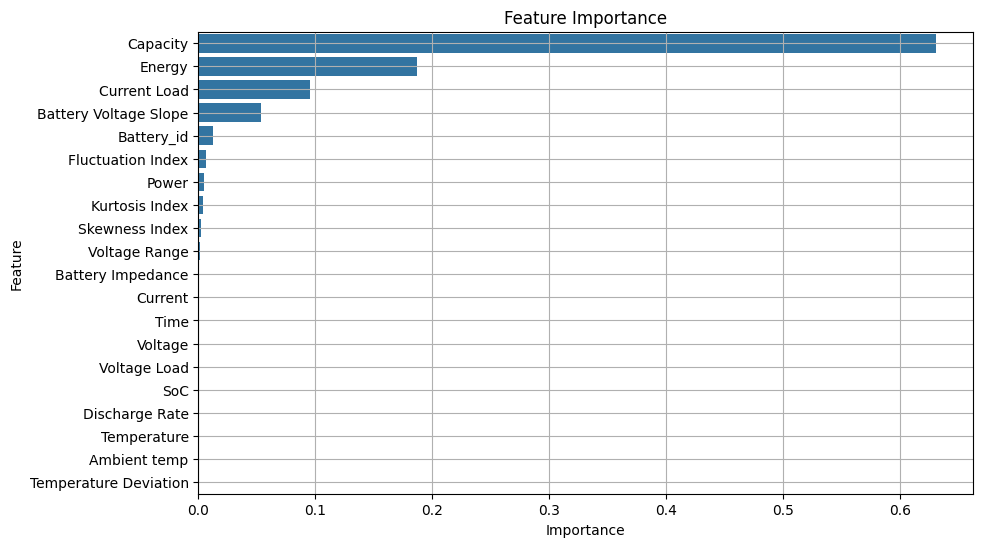

                  Feature    Importance
11               Capacity  6.311099e-01
14                 Energy  1.871441e-01
5            Current Load  9.582323e-02
15  Battery Voltage Slope  5.380346e-02
0              Battery_id  1.238752e-02
8       Fluctuation Index  6.577790e-03
18                  Power  4.916746e-03
10         Kurtosis Index  4.056721e-03
9          Skewness Index  2.075115e-03
16          Voltage Range  1.369867e-03
17      Battery Impedance  7.348649e-04
3                 Current  6.377005e-07
7                    Time  1.121352e-08
1                 Voltage  0.000000e+00
6            Voltage Load  0.000000e+00
12                    SoC  0.000000e+00
13         Discharge Rate  0.000000e+00
4             Temperature  0.000000e+00
2            Ambient temp  0.000000e+00
19  Temperature Deviation  0.000000e+00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

input_data = data[['Battery_id', 'Cycle Number', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
X = input_data
y = data['RUL']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=5,
    min_child_weight=2,
    subsample=0.6,
    n_estimators=100
)

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = (-cv_scores) ** 0.5

print("Cross-Validation RMSE Scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", cv_rmse.mean())

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred)
print("R²:", r2)

n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R²:", adjusted_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 166], [0, 166], color='red', linestyle='--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlim(0, 166)
plt.ylim(0, 166)
plt.grid()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

feature_importance = xgboost_model.feature_importances_
feature_names = input_data.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.grid()
plt.show()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

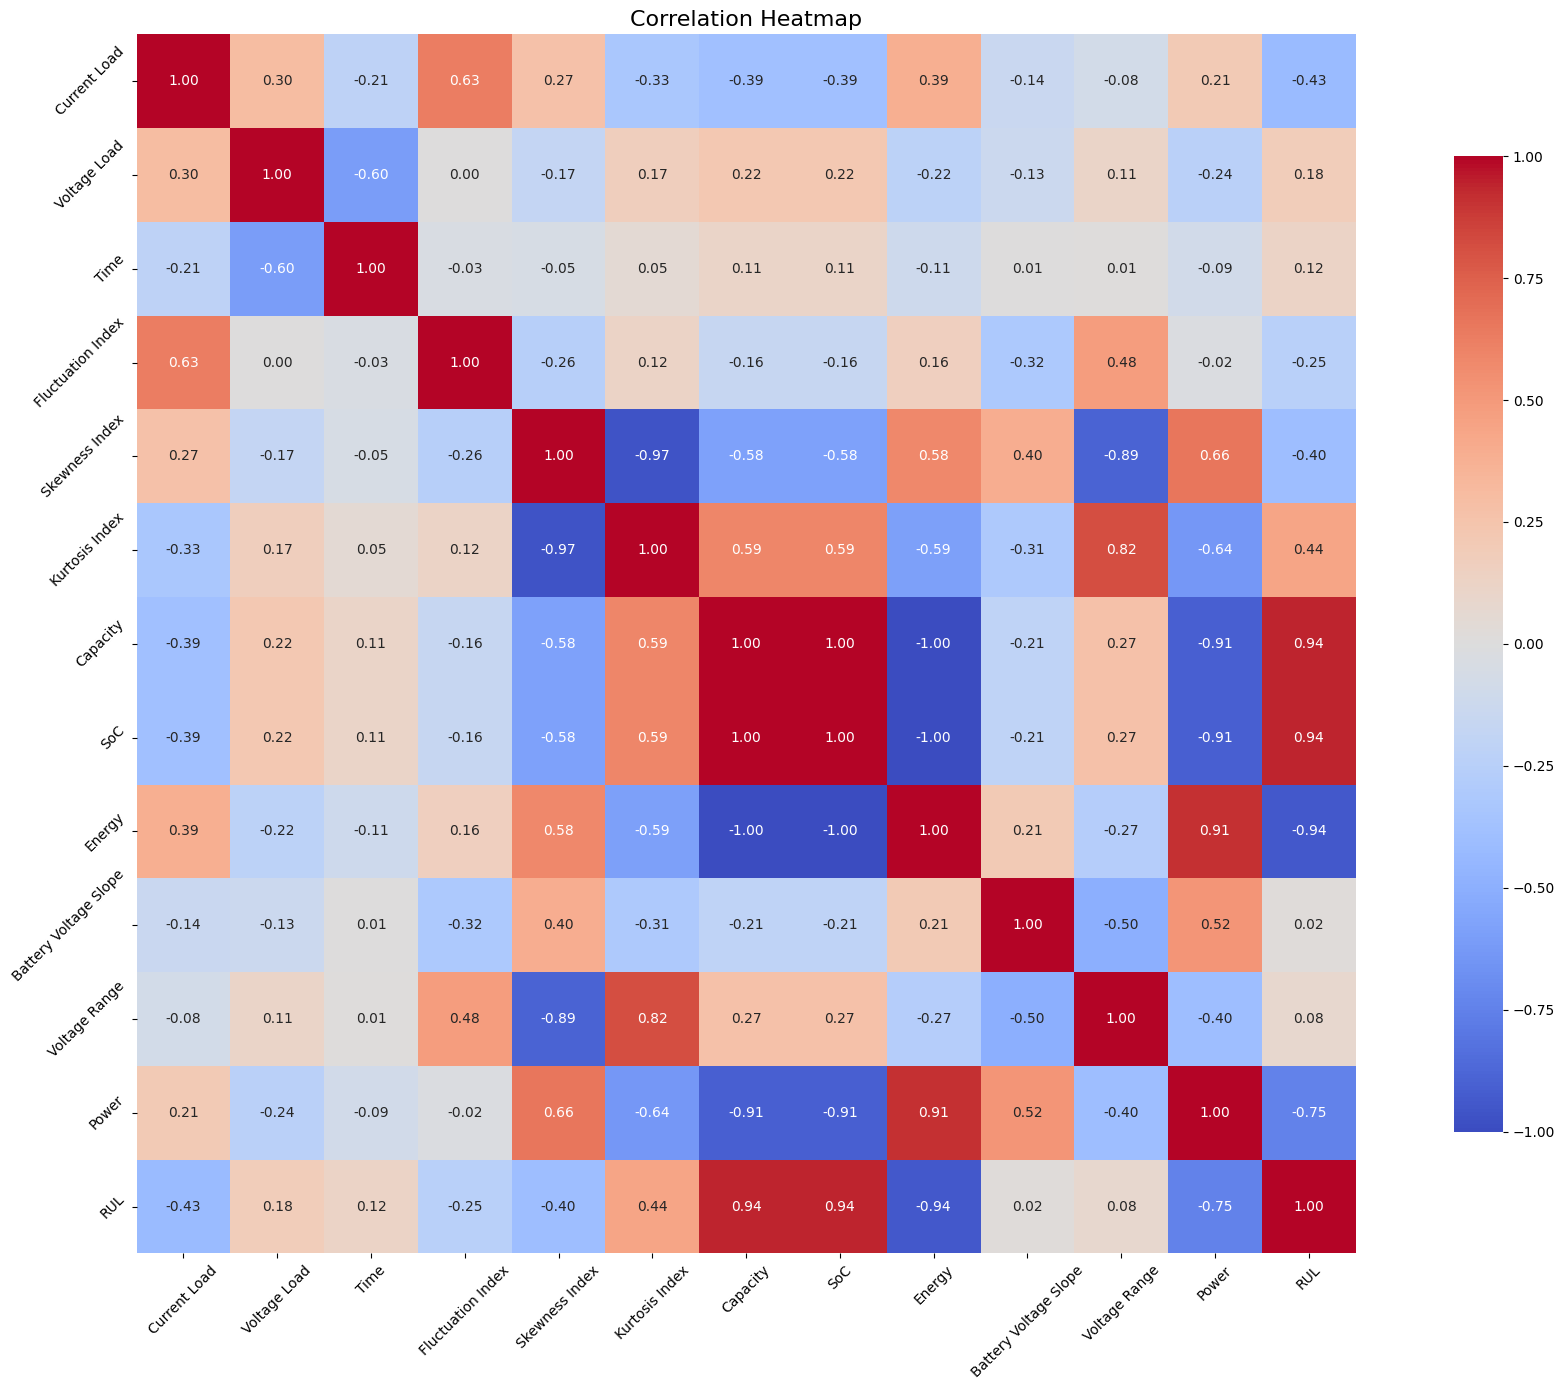

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features
input_data = data[['Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Energy', 'Battery Voltage Slope',
       'Voltage Range',  'Power', 'RUL']]

# Calculate the correlation matrix
correlation_matrix = input_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Cross-Validation RMSE Scores: [0.0017374  0.00614563 0.00284728 0.00702655 0.00081423]
Mean Cross-Validation RMSE: 0.0037142188479824456
Test MSE: 4.0651500874942904e-07
Test RMSE: 0.0006375852952738394


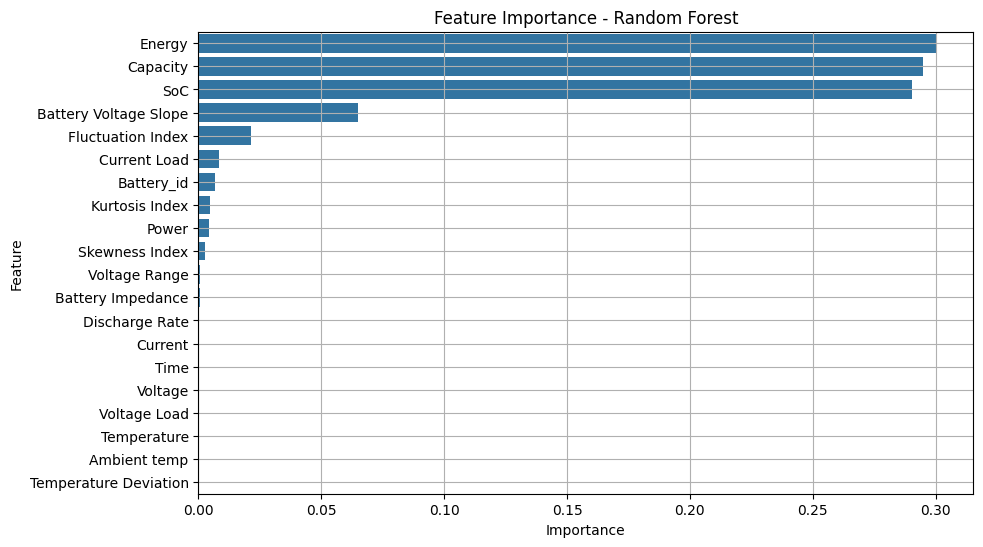

                  Feature    Importance
14                 Energy  3.003446e-01
11               Capacity  2.948269e-01
12                    SoC  2.902058e-01
15  Battery Voltage Slope  6.477321e-02
8       Fluctuation Index  2.159386e-02
5            Current Load  8.451631e-03
0              Battery_id  6.640203e-03
10         Kurtosis Index  4.833634e-03
18                  Power  4.289689e-03
9          Skewness Index  2.557671e-03
16          Voltage Range  7.428451e-04
17      Battery Impedance  7.399208e-04
13         Discharge Rate  6.922928e-08
3                 Current  3.823243e-08
7                    Time  0.000000e+00
1                 Voltage  0.000000e+00
6            Voltage Load  0.000000e+00
4             Temperature  0.000000e+00
2            Ambient temp  0.000000e+00
19  Temperature Deviation  0.000000e+00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Replace with your actual data loading process
# data = pd.read_csv('your_battery_data.csv')

# Prepare your input features and target variable
X = data[['Battery_id', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity',
       'SoC', 'Discharge Rate', 'Energy', 'Battery Voltage Slope',
       'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation']]
y = data['RUL']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,     # None means nodes are expanded until all leaves are pure
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE from MSE scores
cv_rmse = (-cv_scores) ** 0.5

# Output the results of cross-validation
print("Cross-Validation RMSE Scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", cv_rmse.mean())

# Fit the model on the entire training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

# Feature Importance
feature_importance = rf_model.feature_importances_
feature_names = X.columns  # Column names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.grid()
plt.show()
print(importance_df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare your input features and target variable
input_data = data[['Battery_id', 'Voltage', 'Ambient temp', 'Current',
       'Temperature', 'Current Load', 'Voltage Load', 'Time',
       'Fluctuation Index', 'Skewness Index', 'Kurtosis Index', 'Capacity']]
X = input_data
y = data['RUL']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Support Vector Regressor
svr_model = SVR(kernel='rbf')  # You can choose other kernels like 'linear', 'poly', etc.

# Perform cross-validation
cv_scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE from MSE scores
cv_rmse = (-cv_scores) ** 0.5

# Output the results of cross-validation
print("Cross-Validation RMSE Scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", cv_rmse.mean())

# Fit the model on the entire training set
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svr_model.predict(X_test)

# Calculate the Mean Squared Error on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5

# Calculate R² and Adjusted R²
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("R²:", r2)
print("Adjusted R²:", adjusted_r2)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 166], [0, 166], color='red', linestyle='--')  # Diagonal line for reference
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL using SVR')
plt.xlim(0, 166)
plt.ylim(0, 166)
plt.grid()
plt.show()

# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution for SVR')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

KeyboardInterrupt: 

Feature statistics after scaling: [-7.61193310e-16  1.68215458e-15  7.73742134e-16  7.34565317e-16
 -3.10843557e-15  0.00000000e+00] [1. 1. 1. 1. 1. 0.]
Epoch 1/5
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 356s 121ms/step - loss: 4892.7876
Epoch 2/5
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 361s 114ms/step - loss: 4352.8037
Epoch 3/5
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 402s 121ms/step - loss: 4336.3101
Epoch 4/5
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 402s 128ms/step - loss: 4340.3037
Epoch 5/5
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 371s 128ms/step - loss: 4321.5269


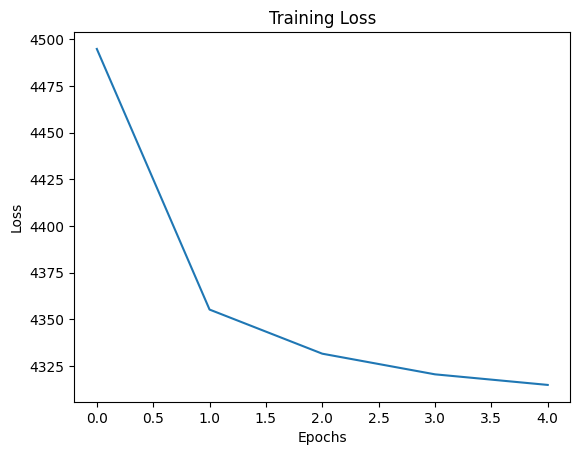

5804/5804 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


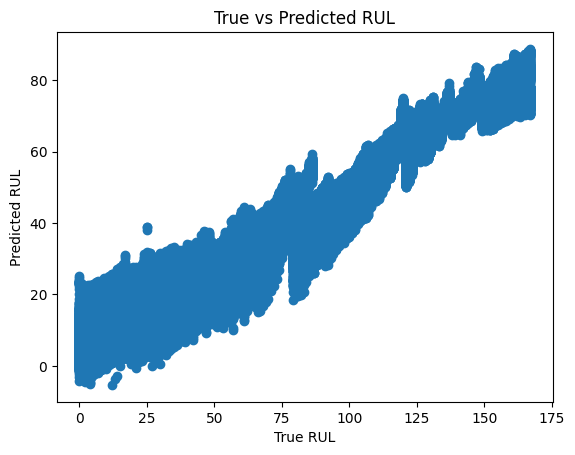

In [ ]:
# Step 1: Data Preprocessing
# Load the dataset (ensure you load your dataset correctly)
# Example: data = pd.read_csv('your_data.csv')
# For illustration, I'm assuming a placeholder `data` DataFrame.



# Select relevant features for the model
features = ['Current', 'Temperature', 'Capacity', 'SoC', 'Voltage', 'Ambient temp']
X = data[features].values
y = data['RUL'].values  # Target variable

# Normalize the features for better convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature statistics after scaling (for debugging)
print("Feature statistics after scaling:", np.mean(X_scaled, axis=0), np.std(X_scaled, axis=0))

# Step 2: Build the Physics-Informed Neural Network Model

# Define a simple MLP model for PINN
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(1)  # Output layer for RUL

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Instantiate the model
model = PINN()

# Step 3: Physics-Informed Loss Function
def physics_informed_loss(y_true, y_pred, X):
    """
    Physics-informed loss function incorporating battery aging model.
    Simplified aging model with scaling for numerical stability.
    """
    # Unpack inputs
    current = X[:, 0]  # Current
    temperature = X[:, 1]  # Temperature
    cycle = X[:, 2]  # Cycle Number

    # Constants for simplified aging model
    k = 1e-5  # Rate constant (A^-1)
    E_a = 0.3  # Activation energy (eV)
    alpha = 1.0  # Exponent

    # Apply a small epsilon to temperature to avoid division by zero
    epsilon = 1e-6
    temperature = temperature + epsilon  # Ensures temperature is never zero

    # Simplified capacity fade model (like Peukert’s law)
    aging_term = k * current**alpha * tf.exp(-E_a / (8.314 * temperature)) * cycle

    # Scale the aging term for better stability
    aging_term = tf.clip_by_value(aging_term, 1e-3, 1e3)  # Clip values to avoid overflow

    # Ensure both aging_term and y_pred are of type float32
    aging_term = tf.cast(aging_term, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32

    # Physics-informed loss
    physical_loss = tf.reduce_mean(tf.square(aging_term - y_pred))

    # MSE loss (standard loss for regression)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Total loss is a combination of physical and standard loss
    total_loss = mse_loss + physical_loss
    return total_loss

# Step 4: Compile the model with custom loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, X_scaled))

# Step 5: Train the model
history = model.fit(X_scaled, y, epochs=5, batch_size=16)

# Step 6: Visualize the results (optional)
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Step 7: Evaluate the model (optional)
y_pred = model.predict(X_scaled)

# Plot RUL predictions vs actual
plt.scatter(y, y_pred)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted RUL')
plt.show()

Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1765.0187 - mae: 23.9943
Epoch 2/15
  62/2902 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 914.9374 - mae: 11.9545

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


2902/2902 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 914.1436 - mae: 11.8571
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 899.7338 - mae: 11.1683
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 901.7920 - mae: 10.8867
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 897.7440 - mae: 10.6737
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 899.1703 - mae: 10.5629
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 895.0723 - mae: 10.4415
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 896.0824 - mae: 10.3746
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 896.9470 - mae: 10.3488
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 893.2354 - mae: 10.2919
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 895.4333 - mae: 10.2565
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 895.2960 - mae: 10.2118
Epoch 13/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - 

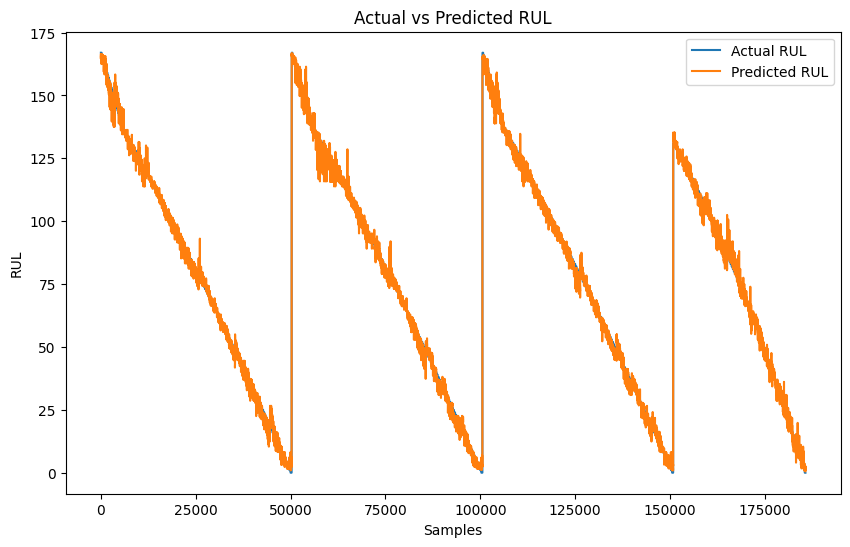

In [ ]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# number of time steps
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks= [early_stopping], verbose=1)

# Extract CNN features for XGBoost
X_cnn_features = cnn_model.predict(X_seq)

# Train XGBoost model on CNN features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_features, y_seq)

# XGBoost
y_pred = xgb_model.predict(X_cnn_features)

# Evaluating
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)
print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# actual vs predicted RUL plot
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

Epoch 1/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1374.1289 - mae: 21.1320 - val_loss: 158.2748 - val_mae: 5.1823
Epoch 2/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 155.8669 - mae: 4.9851 - val_loss: 146.7783 - val_mae: 4.5172
Epoch 3/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 147.3265 - mae: 4.4151 - val_loss: 141.5296 - val_mae: 4.0335
Epoch 4/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 143.1157 - mae: 4.0587 - val_loss: 140.8164 - val_mae: 4.0424
Epoch 5/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 141.7586 - mae: 3.9177 - val_loss: 138.8263 - val_mae: 3.7524
Epoch 6/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 139.2895 - mae: 3.7544 - val_loss: 138.5445 - val_mae: 3.9982
Epoch 7/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 138.6495 - mae: 3.6717 - val_loss: 137.1059 - val_mae: 3.5843
Epoch 8/15
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 137.7794 - mae: 3.5550 - val_loss: 135.1188 - val_mae: 3.3954
Epoch 

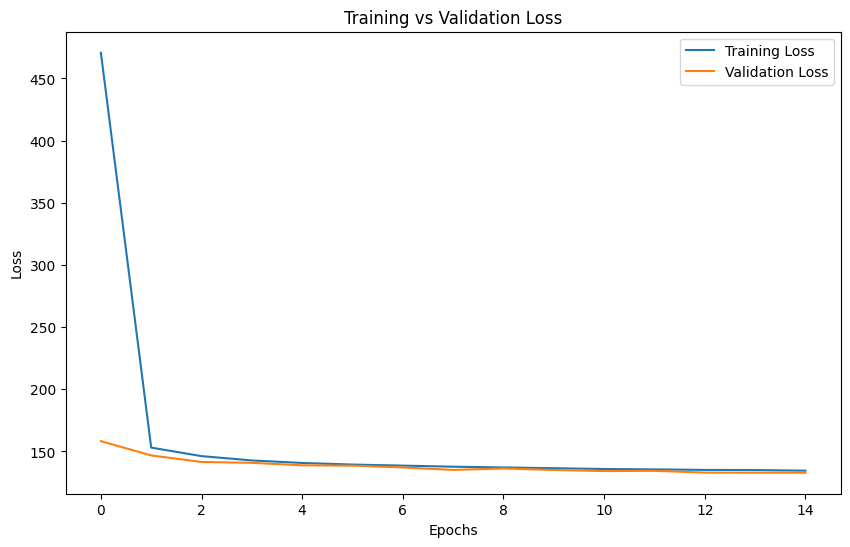

4063/4063 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
871/871 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
871/871 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Validation Set Metrics:
Mean Absolute Error (MAE): 1.5869526441027848
Mean Squared Error (MSE): 4.8240705716543335
Root Mean Squared Error (RMSE): 2.196376691657042
R² (Coefficient of Determination): 0.9975391030311584
Test Set Metrics:
Mean Absolute Error (MAE): 1.5945028758303204
Mean Squared Error (MSE): 5.227743067058644
Root Mean Squared Error (RMSE): 2.2864258280247456
R² (Coefficient of Determination): 0.9973307847976685


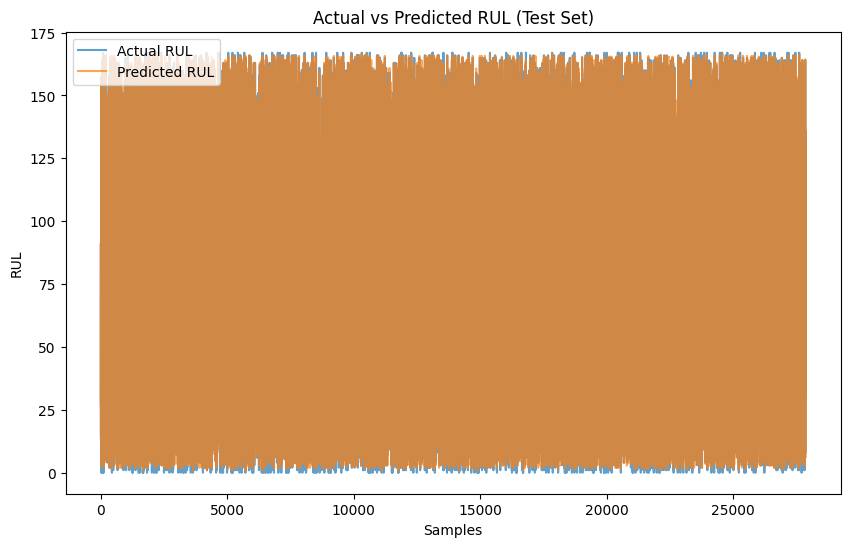

In [ ]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#CNN model
cnn_model = models.Sequential([
    Input(shape=(time_steps, X_seq.shape[2])),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Flatten(),  # Ensure the output is 1D
    layers.Dense(64, activation='relu'),
])

# CNN model with validation data
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15, batch_size=64, callbacks= [early_stopping], verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN features from the training, validation, and test sets
X_train_cnn = cnn_model.predict(X_train)
X_val_cnn = cnn_model.predict(X_val)
X_test_cnn = cnn_model.predict(X_test)

# Train XGBoost model on CNN-extracted training features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn, y_train)

# Evaluate on validation and test sets to check for overfitting
y_val_pred = xgb_model.predict(X_val_cnn)
y_test_pred = xgb_model.predict(X_test_cnn)

# Metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted RUL for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL', alpha=0.7)
plt.plot(y_test_pred, label='Predicted RUL', alpha=0.7)
plt.title('Actual vs Predicted RUL (Test Set)')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 147s 31ms/step - loss: 705.1190 - mae: 17.3401 - val_loss: 341.0981 - val_mae: 14.8954 - learning_rate: 0.0010
Epoch 2/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 143s 31ms/step - loss: 158.9818 - mae: 9.5822 - val_loss: 374.7882 - val_mae: 16.2548 - learning_rate: 0.0010
Epoch 3/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 196s 29ms/step - loss: 135.7174 - mae: 8.7802 - val_loss: 314.2085 - val_mae: 14.9340 - learning_rate: 0.0010
Epoch 4/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 141s 30ms/step - loss: 120.6321 - mae: 8.3373 - val_loss: 339.0796 - val_mae: 15.6645 - learning_rate: 0.0010
Epoch 5/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 144s 31ms/step - loss: 106.7867 - mae: 7.8063 - val_loss: 347.8302 - val_mae: 16.3077 - learning_rate: 0.0010
Epoch 6/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 195s 29ms/step - loss: 100.7959 - mae: 7.6270 - val_loss: 269.1798 - val_mae: 13.7709 - learning_rate: 0.0010
Epoch 7/50
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 149s 31ms/step - loss: 97.0068 - mae: 7.4568 

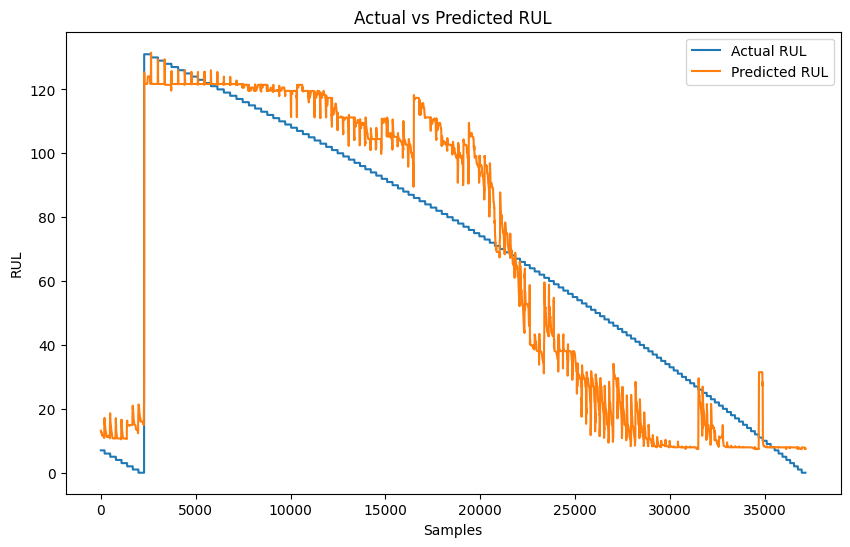

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values  # Remaining Useful Life (RUL) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build the model with improved architecture
model = models.Sequential()

# CNN Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(0.4))

# CNN Layer 2
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# CNN Layer 3
model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.4))

# Bidirectional LSTM Layer
model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=False)))
model.add(layers.Dropout(0.5))

# Dense Layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))

# Output Layer
model.add(layers.Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Model - MAE: {mae}")

# Predict with the model
y_pred = model.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 87s 18ms/step - loss: 1020.0698 - mae: 22.4524 - val_loss: 1841.9077 - val_mae: 35.4693 - learning_rate: 0.0010
Epoch 2/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - loss: 249.3030 - mae: 11.9590 - val_loss: 2186.5627 - val_mae: 39.6313 - learning_rate: 0.0010
Epoch 3/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - loss: 210.2555 - mae: 10.9311 - val_loss: 2293.4519 - val_mae: 40.3238 - learning_rate: 0.0010
Epoch 4/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 167.9828 - mae: 9.6550 - val_loss: 2258.8108 - val_mae: 39.7386 - learning_rate: 5.0000e-04
Epoch 5/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 73s 16ms/step - loss: 154.6540 - mae: 9.2429 - val_loss: 1932.6984 - val_mae: 35.5847 - learning_rate: 5.0000e-04
Epoch 6/15
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - loss: 135.6728 - mae: 8.6519 - val_loss: 2196.9558 - val_mae: 38.6027 - learning_rate: 2.5000e-04
4643/4643 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step
1161/1161 ━━━━━━━━━━━━━━━━━━

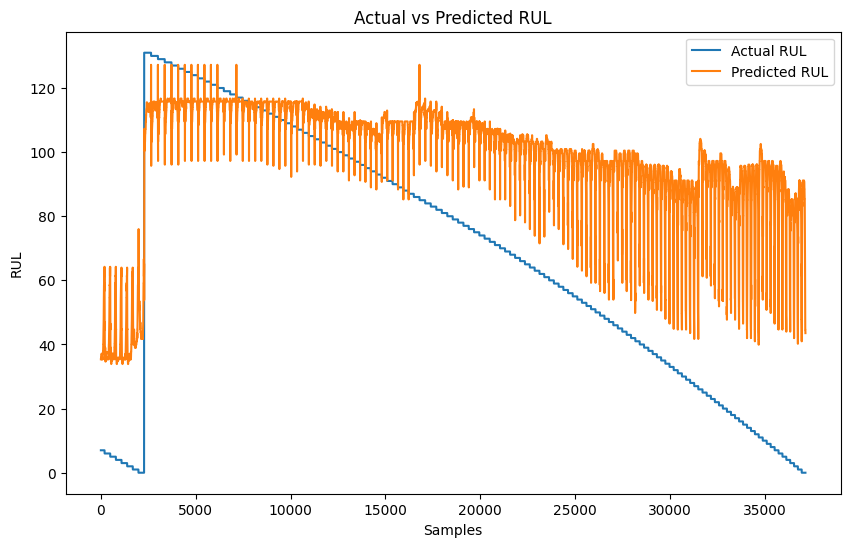

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Function to create sequences for time-series data
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])  # Use the RUL of the last time step in the sequence
    return np.array(X), np.array(y)

# Extract features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values  # Remaining Useful Life (RUL) is the target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split into training and validation sets
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Build CNN-LSTM model with 2 CNN layers and reduced LSTM units
cnn_lstm_model = Sequential()

# CNN Layer 1
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# CNN Layer 2
cnn_lstm_model.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Bidirectional LSTM Layer with fewer units
cnn_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Reduced units
cnn_lstm_model.add(Dropout(0.4))

# Dense Layer
cnn_lstm_model.add(Dense(64, activation='relu'))  # Reduced units
cnn_lstm_model.add(Dropout(0.3))  # Reduced dropout rate

# Output Layer
cnn_lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
cnn_lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for learning rate adjustment and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)  # Reduced patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience

# Train the CNN-LSTM model
cnn_lstm_model.fit(
    X_train, y_train,
    epochs=15,  # Reduced epochs
    batch_size=32,  # Kept batch size
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Extract CNN features
cnn_features_train = cnn_lstm_model.predict(X_train)
cnn_features_val = cnn_lstm_model.predict(X_val)

# Reshape the CNN features to be used by XGBoost
cnn_features_train_reshaped = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_val_reshaped = cnn_features_val.reshape(cnn_features_val.shape[0], -1)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(cnn_features_train_reshaped, y_train)

# Predict with XGBoost model
y_pred_xgboost = xg_reg.predict(cnn_features_val_reshaped)

# Evaluate the model performance
mse = mean_squared_error(y_val, y_pred_xgboost)
mae = mean_absolute_error(y_val, y_pred_xgboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_xgboost)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plot actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual RUL')
plt.plot(y_pred_xgboost, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 4894.7437 - mae: 56.2673
Epoch 2/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 405.0149 - mae: 10.3400
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 28.4259 - mae: 2.9756
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 8.1744 - mae: 1.9432
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 5.3218 - mae: 1.5680
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 4.3034 - mae: 1.3941
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 3.6103 - mae: 1.2462
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 2.9886 - mae: 1.1235
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2.6291 - mae: 1.0388
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.0965 - mae: 0.9171
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 1.7550 - mae: 0.8378
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1

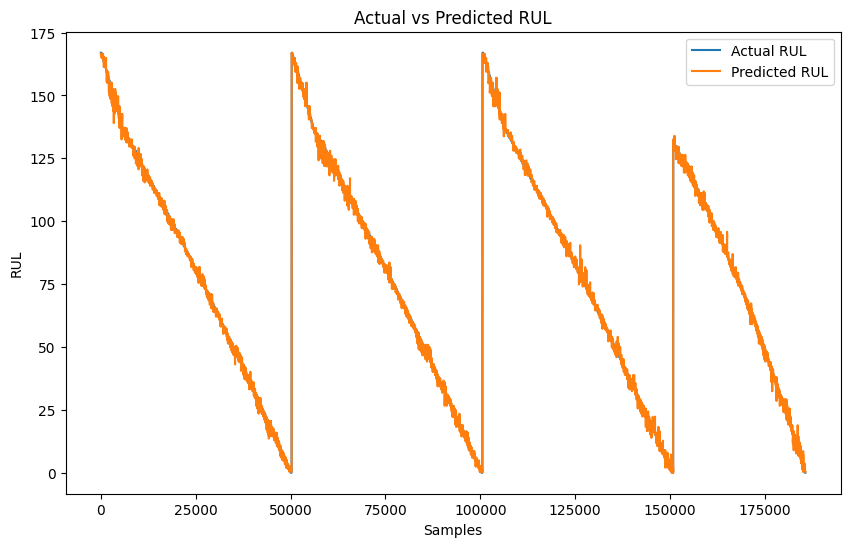

In [ ]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define sequence length
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),  # LSTM for temporal dependencies

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Extract CNN-LSTM features for XGBoost
X_cnn_lstm_features = cnn_lstm_model.predict(X_seq)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_cnn_lstm_features, y_seq)

# Predict RUL
y_pred = xgb_model.predict(X_cnn_lstm_features)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Prepare your features and target
features = ['Voltage', 'Ambient temp', 'Current', 'Temperature',
            'Current Load', 'Voltage Load', 'Fluctuation Index',
            'Skewness Index', 'Kurtosis Index', 'Capacity', 'SoC',
            'Discharge Rate', 'Energy', 'Battery Voltage Slope',
            'Voltage Range', 'Battery Impedance', 'Power', 'Temperature Deviation', 'Time']
X = data[features].values
y = data['RUL'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
time_steps = 10
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps)
y_seq = y_seq.reshape(-1, 1)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(time_steps, X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),  # LSTM for temporal dependencies

    # Dense layer to flatten output for XGBoost
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model with validation data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract CNN-LSTM features for XGBoost
X_train_cnn_lstm = cnn_lstm_model.predict(X_train)
X_val_cnn_lstm = cnn_lstm_model.predict(X_val)
X_test_cnn_lstm = cnn_lstm_model.predict(X_test)

# Train XGBoost model on CNN-LSTM features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(X_train_cnn_lstm, y_train)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_cnn_lstm)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Mean Squared Error (MSE): {val_mse}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')
print(f'R² (Coefficient of Determination): {val_r2}')

# Evaluate on test set
y_test_pred = xgb_model.predict(X_test_cnn_lstm)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')
print(f'R² (Coefficient of Determination): {test_r2}')

# Plot actual vs predicted RUL for test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL (Test Set)')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()

NameError: name 'data' is not defined

Epoch 1/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 1205.6927 - mae: 18.8237
Epoch 2/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 21.1747 - mae: 3.2657
Epoch 3/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 17.1924 - mae: 2.8812
Epoch 4/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 14.1633 - mae: 2.5981
Epoch 5/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 11.4717 - mae: 2.3153
Epoch 6/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 10.1990 - mae: 2.1364
Epoch 7/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 8.7598 - mae: 1.9775
Epoch 8/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 9.3289 - mae: 1.9803
Epoch 9/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 8.1294 - mae: 1.8254
Epoch 10/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 7.4519 - mae: 1.7375
Epoch 11/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 6.9993 - mae: 1.6660
Epoch 12/15
2902/2902 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 6

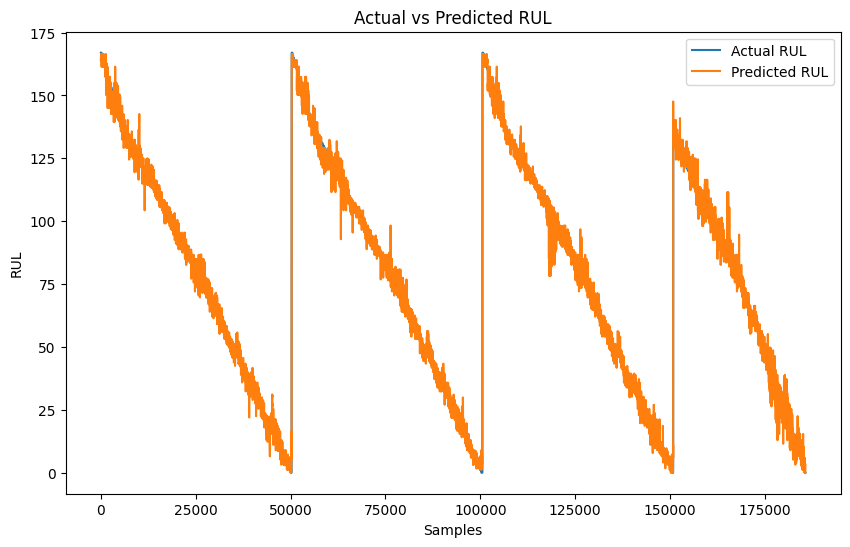

In [ ]:
# Function to create sequences for time-series prediction
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])
        y.append(target[i + time_steps - 1])
    return np.array(X), np.array(y)

# Feature extraction using FFT (Fourier Transform)
def extract_fourier_features(signal):
    """Extract features using FFT."""
    fft_result = fft(signal)
    fft_abs = np.abs(fft_result)
    fft_freq = np.fft.fftfreq(len(signal))
    # Keep only the positive frequencies
    positive_freq = fft_freq[:len(fft_freq)//2]
    positive_abs = fft_abs[:len(fft_freq)//2]

    # Extract common frequency-domain features
    mean_freq = np.mean(positive_abs)
    std_freq = np.std(positive_abs)
    max_freq = np.max(positive_abs)
    dominant_freq = positive_freq[np.argmax(positive_abs)]

    return [mean_freq, std_freq, max_freq, dominant_freq]

# Feature extraction using Wavelet Transform (WT)
def extract_wavelet_features(signal):
    """Extract features using Wavelet Transform."""
    coeffs = pywt.wavedec(signal, 'db4', level=min(4, pywt.dwt_max_level(len(signal), pywt.Wavelet('db4'))))
    # Extract features from the wavelet coefficients
    wavelet_features = []
    for coeff in coeffs:
        wavelet_features.append(np.mean(coeff))
        wavelet_features.append(np.std(coeff))
        wavelet_features.append(np.max(coeff))
    return wavelet_features

# Extract features from each column (Voltage, Current, Temperature, etc.) in the dataset
def extract_all_features(data, features, time_steps):
    all_features = []
    for i in range(len(data) - time_steps):  # Loop to form sequences of time_steps length
        feature_vector = []
        for feature in features:
            signal = data[feature].iloc[i:i + time_steps].values  # Extract the time-series for each feature
            # Extract FFT and Wavelet features for the signal
            fft_features = extract_fourier_features(signal)
            wavelet_features = extract_wavelet_features(signal)
            feature_vector.extend(fft_features + wavelet_features)  # Combine both feature sets
        all_features.append(feature_vector)
    return np.array(all_features)

# Assuming `data` is your DataFrame containing the features like Voltage, Current, etc.
# And `features` is a list of feature column names
features = ['Voltage', 'Current', 'Temperature',
            'Current Load', 'Voltage Load','Capacity', 'SoC',
            'Discharge Rate', 'Energy','Battery Impedance', 'Power', 'Time']

# Normalize the features
scaler = StandardScaler()

# Extract features and target variable (RUL)
X_features = extract_all_features(data, features, time_steps=10)  # 10 is the chosen time_steps length
X_scaled = scaler.fit_transform(X_features)  # Normalize the features
time_steps = 10  # Or any value of your choice for sequence length
# Target variable (RUL values)
y = data['RUL'].values[time_steps:]  # Ensure correct target indexing

# Create sequences (X_seq) and targets (y_seq)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=10)

# CNN-LSTM Model
cnn_lstm_model = Sequential([
    layers.Input(shape=(X_seq.shape[1], X_seq.shape[2])),

    # CNN layers
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),

    # LSTM layer
    layers.LSTM(64, return_sequences=False),

    # Dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_seq, y_seq, epochs=15, batch_size=64, callbacks=[early_stopping], verbose=1)

# Predict RUL with CNN-LSTM
y_cnn_lstm_pred = cnn_lstm_model.predict(X_seq)

# Train XGBoost model (Optional - If you want to add an additional layer of prediction)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100)
xgb_model.fit(y_cnn_lstm_pred, y_seq)  # Train with CNN-LSTM features

# Predict RUL using XGBoost
y_pred = xgb_model.predict(y_cnn_lstm_pred)

# Evaluate model
mae = mean_absolute_error(y_seq, y_pred)
mse = mean_squared_error(y_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_seq, y_pred)

print(f'Mean Absolute Error (MAE) for RUL prediction: {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² (Coefficient of Determination): {r2}')

# Plot Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_seq, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()